# <center>ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА
HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Оригинальный датасет: [“Data Science Job Salaries”](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

Исследуйте данные и сделайте выводы по полученным результатам. Подкрепите свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверьте, являются ли выводы статистически значимыми.

В процессе своего анализа вы должны:
* Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
* А также ответить на ключевые вопросы HR-агентства:
    * Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    * Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    * Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    * Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Описание столбцов:**

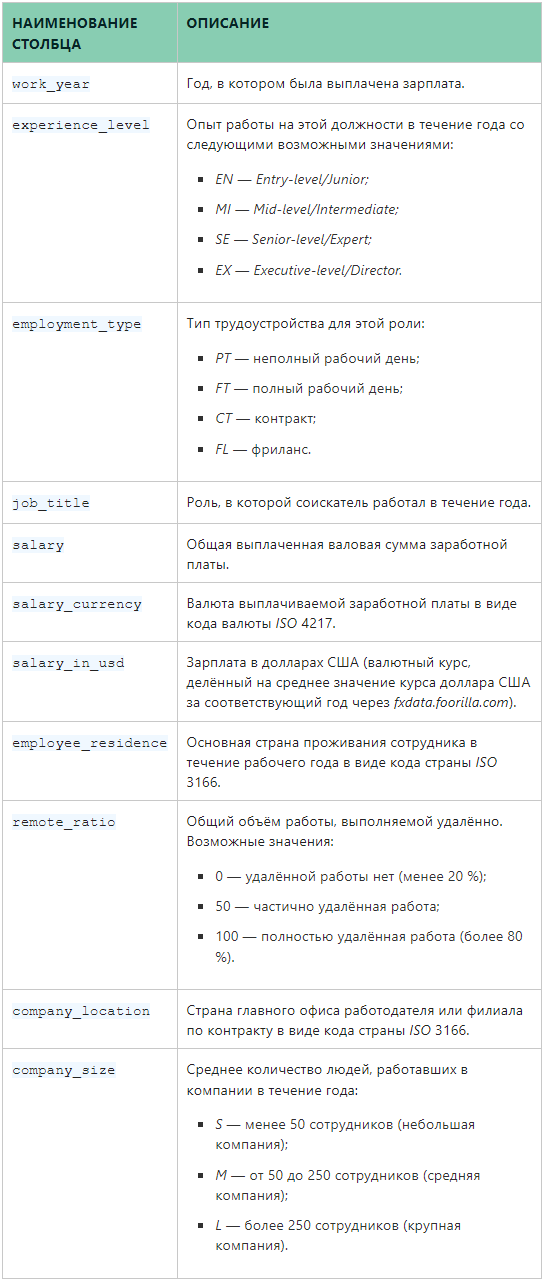

## <center>Загрузка и обработка данных

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from scipy import stats
from IPython.core.display import HTML
from pycountry_convert import country_alpha2_to_country_name

pio.renderers.default = 'png'
pio.templates.default = 'plotly_dark'

### Знакомство с данными, наличие пропусков и дубликатов

In [2]:
data = pd.read_csv('F:\SF-DS-practice\Block-3\data\ds_salaries.zip', index_col=0)
display(HTML('<b><font size=5>Характеристики столбцов</font></b>'))
data.info()
display(HTML('<b><font size=5>Пример набора данных</font></b>'))
display(data.sample(5, random_state=42))
display(HTML('<b><font size=5>Характеристики категориальных столбцов</font></b>'))
display(data.describe(include=object).T)
display(HTML('<b><font size=5>Характеристики числовых столбцов</font></b>'))
display(data.describe().T)
print('Количество дубликатов:', data.duplicated().sum(), '\n')
print('Количество пропусков:', data.isna().sum().sum(), '\n')
nums_list = [col for col in data.columns if data[col].dtype != object]
cats_list = [col for col in data.columns if data[col].dtype == object]
print(f'Количество числовых столбцов: {len(nums_list)}\n{nums_list}\n')
print(f'Количество категориальных столбцов: {len(cats_list)}\n{cats_list}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
563,2022,SE,FT,Data Engineer,140250,USD,140250,US,100,US,M
289,2022,SE,FT,Data Engineer,135000,USD,135000,US,100,US,M
76,2021,MI,FT,BI Data Analyst,100000,USD,100000,US,100,US,M
78,2021,MI,CT,ML Engineer,270000,USD,270000,US,100,US,L
182,2021,MI,FT,Data Engineer,22000,EUR,26005,RO,0,US,L


,count,unique,top,freq
experience_level,607,4,SE,280
employment_type,607,4,FT,588
job_title,607,50,Data Scientist,143
salary_currency,607,17,USD,398
employee_residence,607,57,US,332
company_location,607,50,US,355
company_size,607,3,M,326


,count,mean,std,min,25%,50%,75%,max
work_year,607.0,2021.405272,6.921330e-01,2020.0,2021.0,2022.0,2022.0,2022.0
salary,607.0,324000.062603,1.544357e+06,4000.0,70000.0,115000.0,165000.0,30400000.0
salary_in_usd,607.0,112297.869852,7.095726e+04,2859.0,62726.0,101570.0,150000.0,600000.0
remote_ratio,607.0,70.922570,4.070913e+01,0.0,50.0,100.0,100.0,100.0


Количество дубликатов: 42 

Количество пропусков: 0 

Количество числовых столбцов: 4
['work_year', 'salary', 'salary_in_usd', 'remote_ratio']

Количество категориальных столбцов: 7
['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']


### Удаление дубликатов из данных

In [3]:
data.drop_duplicates(inplace=True)
print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 0


### Удаление неинформативных признаков
Есть 2 признака: `salary` и `salary_currency`. Нас они не интересуют, т.к. в данных уже есть признак `salary_in_usd`, где все зарплаты приведены к единому масштабу (в долларах США).

In [4]:
data.drop(columns=['salary', 'salary_currency'], inplace=True)

## <center>Разведывательный анализ данных
### Визуальный анализ всех данных

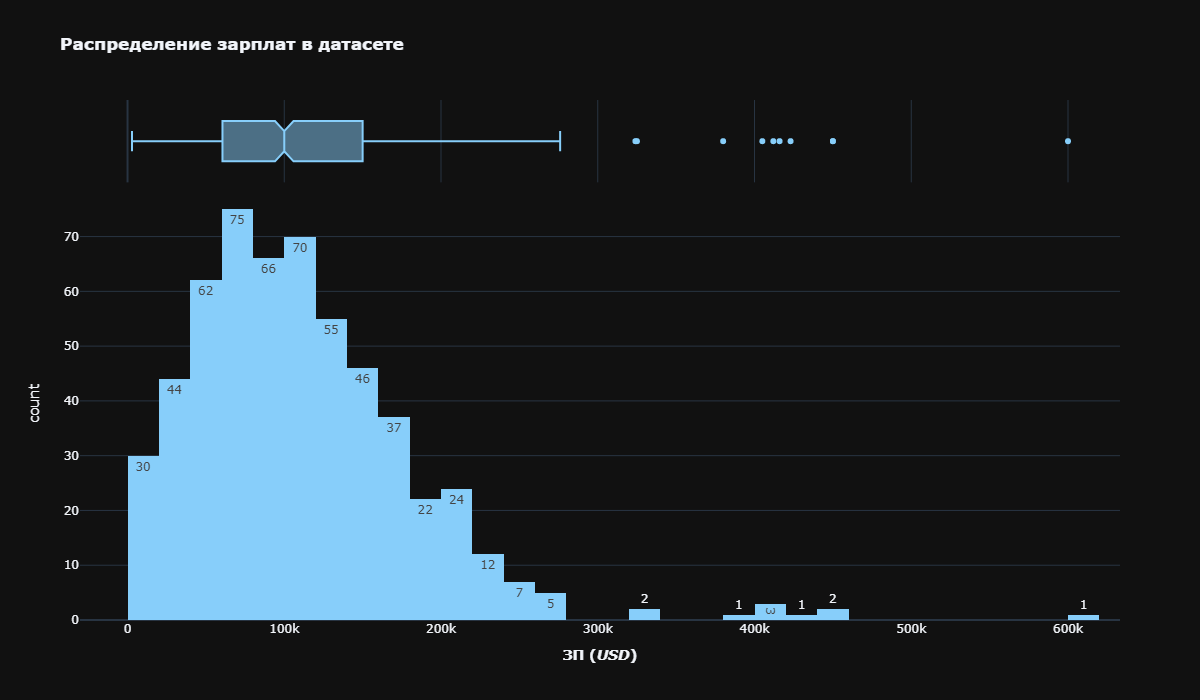

In [5]:
px.histogram(
    data_frame=data,
    x='salary_in_usd',
    title=f'<b>Распределение зарплат в датасете</b>',
    width=1200,
    height=700,
    color_discrete_sequence=['#87CEFA'],
    text_auto=True,
    marginal='box',
    labels={'salary_in_usd': '<b>ЗП (<i>USD</i>)</b>'}
).show()

По графику можно сделать вывод, что распределение зарплат очень похоже на логнормальное.

Прологарифмируем признак, чтобы привести к нормальному распределению. Построим границы $(\mu + 3\sigma)$ и $(\mu - 3\sigma)$ (метод трёх сигм для нормального распределения):
* Желтая пунктирная линия обозначает среднее значение $\mu$
* Красные пунктирные линии обозначают $\mu \pm 3\sigma$
* Красная область обозначает область, которая по методу трёх сигм будет считаться выбросами.

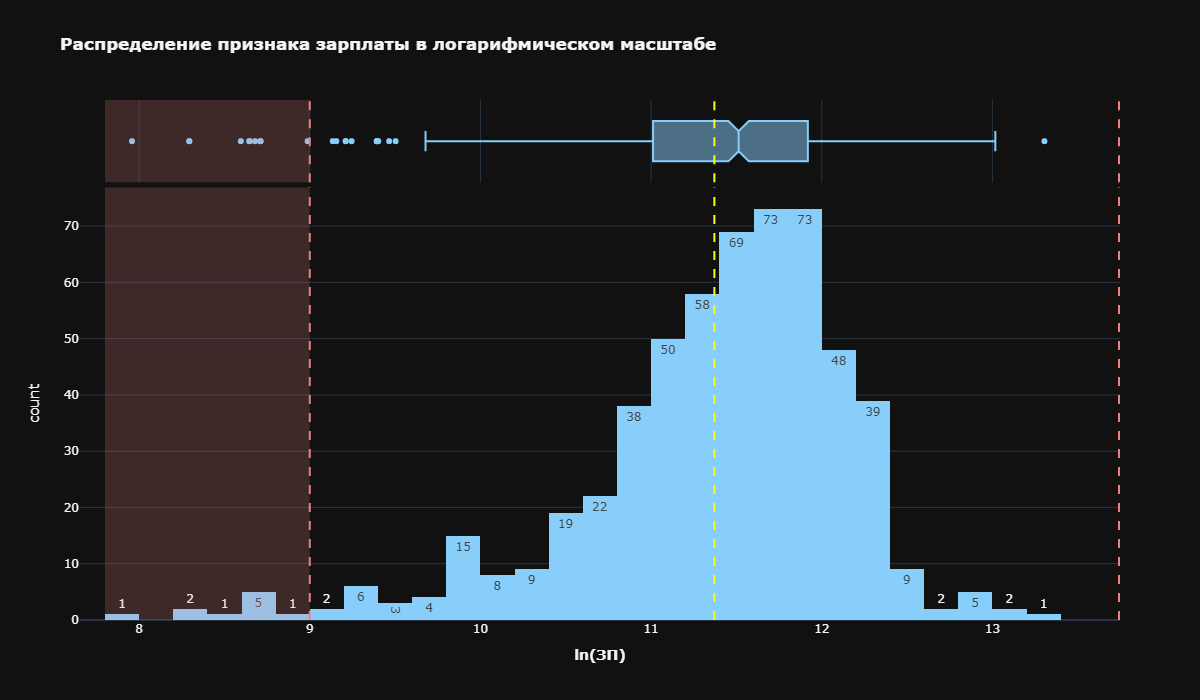

In [6]:
data['salary_log'] = np.log(data['salary_in_usd'])

px.histogram(
    data_frame=data,
    x='salary_log',
    title=f'<b>Распределение признака зарплаты в логарифмическом масштабе</b>',
    width=1200,
    height=700,
    color_discrete_sequence=['#87CEFA'],
    text_auto=True,
    marginal='box',
    labels={'salary_log': '<b>ln(ЗП)</b>'}
).add_vline(
    x=data['salary_log'].mean() - 3*data['salary_log'].std(),
    line_dash='dash',
    line_color='#F08080'
).add_vline(
    x=data['salary_log'].mean() + 3*data['salary_log'].std(),
    line_dash='dash',
    line_color='#F08080',
    name='123'
).add_vrect(
    x0=7.8,
    x1=data['salary_log'].mean() - 3*data['salary_log'].std(),
    fillcolor='#F08080',
    line_width=0,
    opacity=0.2
).add_vline(
    x=data['salary_log'].mean(),
    line_dash='dash',
    line_color='#FFFF00'
).show()

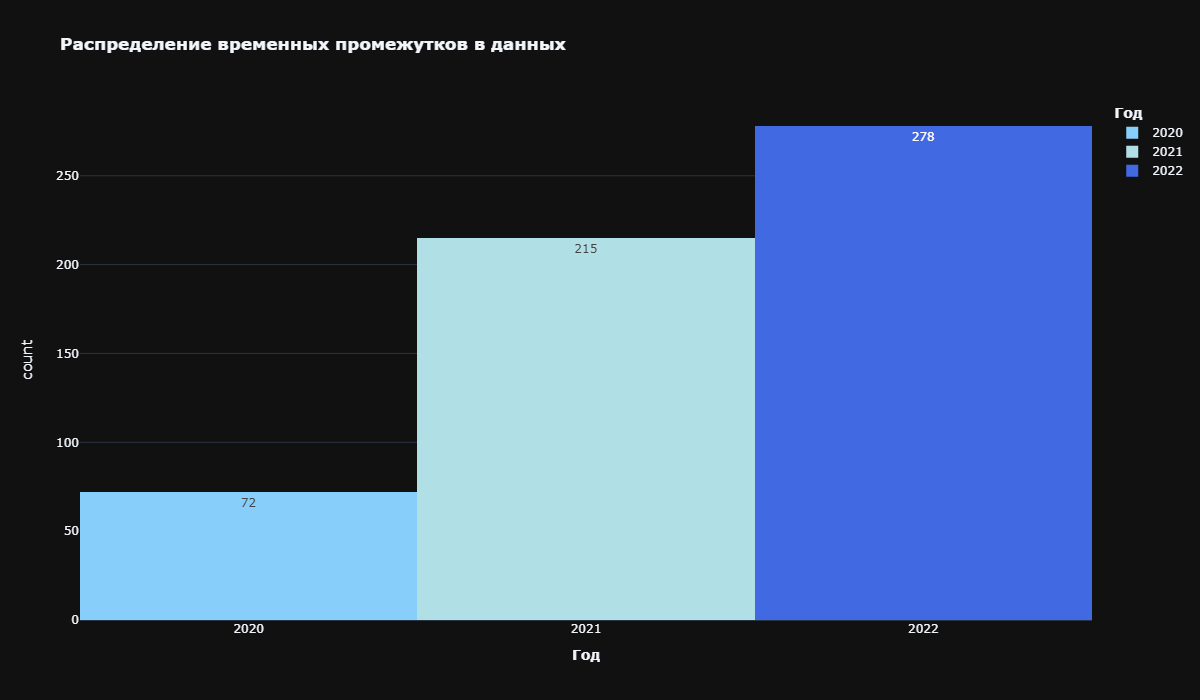

In [7]:
px.histogram(
    data_frame=data,
    x='work_year',
    title=f'<b>Распределение временных промежутков в данных</b>',
    width=1200,
    height=700,
    color_discrete_sequence=['#87CEFA', '#B0E0E6', '#4169E1'],
    text_auto=True,
    nbins=3,
    color='work_year',
    labels={'work_year': '<b>Год</b>'}
).update_xaxes(tickmode='array', tickvals=[2020, 2021, 2022])

По графику можно сделать вывод, что меньше всего наблюдений у нас есть за 2020 г. В датасете преобладают данные за 2021 и 2022 г.

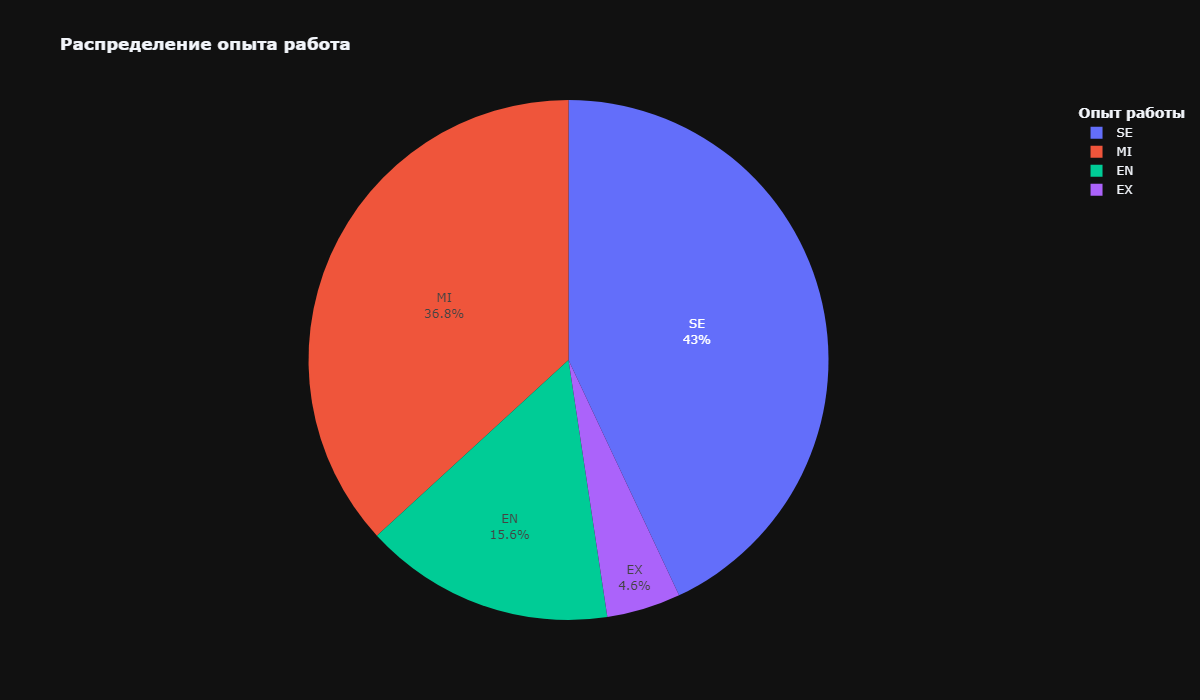

In [8]:
px.pie(
    data_frame=data,
    title=f'<b>Распределение опыта работа</b>',
    names='experience_level',
    width=1200,
    height=700
).update_traces(
    textinfo='percent+label',
    textposition='inside'
).update_layout(
    legend_title='<b>Опыт работы</b>'
).show()

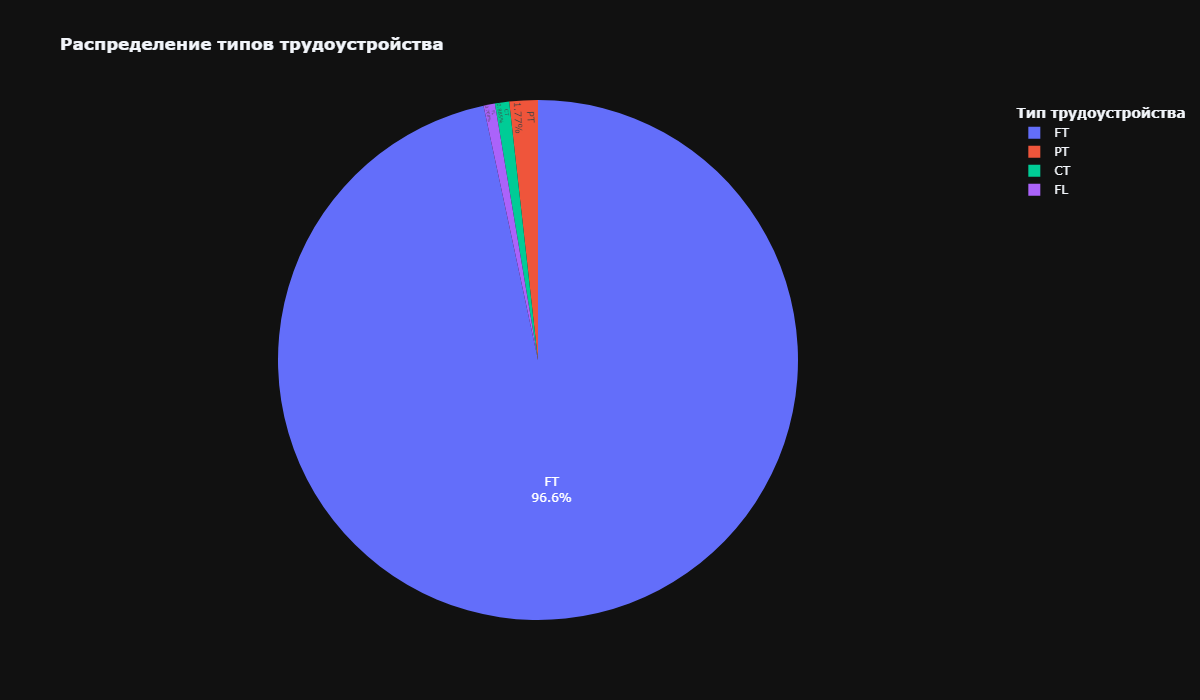

In [9]:
px.pie(
    data_frame=data,
    title=f'<b>Распределение типов трудоустройства</b>',
    names='employment_type',
    width=1200,
    height=700
).update_traces(
    textinfo='percent+label',
    textposition='inside'
).update_layout(
    legend_title='<b>Тип трудоустройства</b>'
).show()

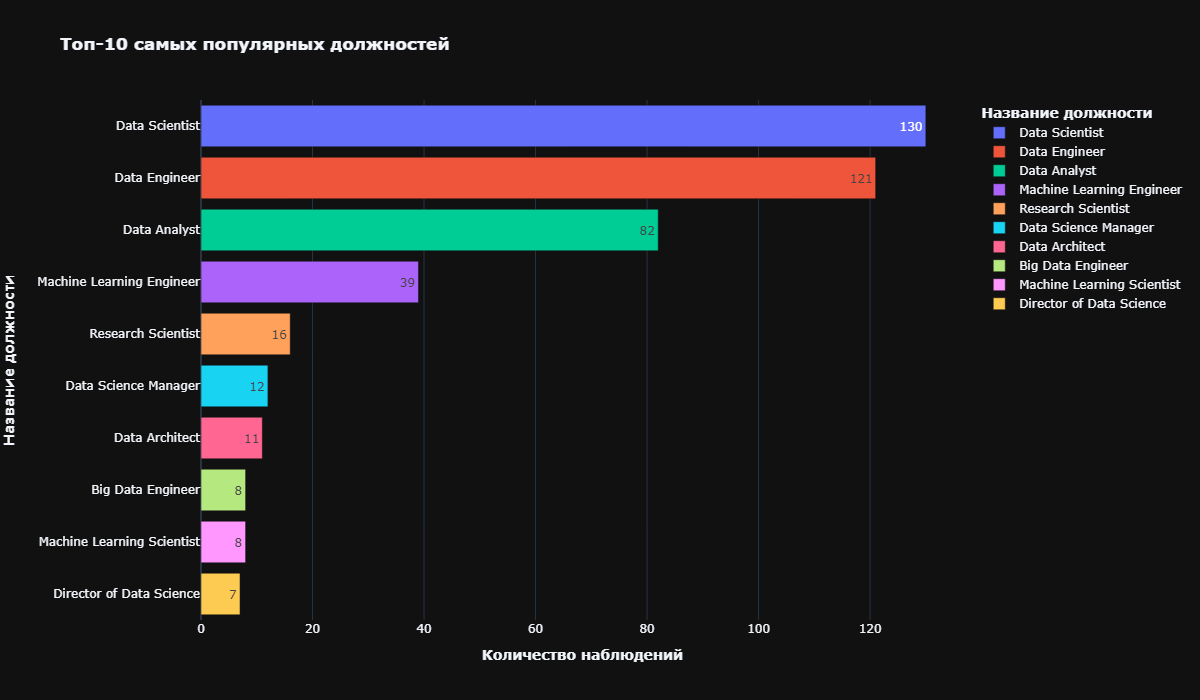

In [10]:
grouped_job = data.groupby(
    by='job_title', 
    as_index=False
)['salary_in_usd'].count().rename(
    columns={'salary_in_usd': 'count'}
).sort_values(
    by='count',
    ascending=False
).head(10)

px.bar(
    data_frame=grouped_job,
    y='job_title',
    x='count',
    title='<b>Топ-10 самых популярных должностей</b>',
    width=1200,
    height=700,
    color='job_title',
    text_auto=True,
    labels={'count': '<b>Количество наблюдений</b>', 'job_title': '<b>Название должности</b>'}
).show()

Конвертируем столбцы со странами из формата *ISO 3166-2* в названия стран для удобства визуализации.

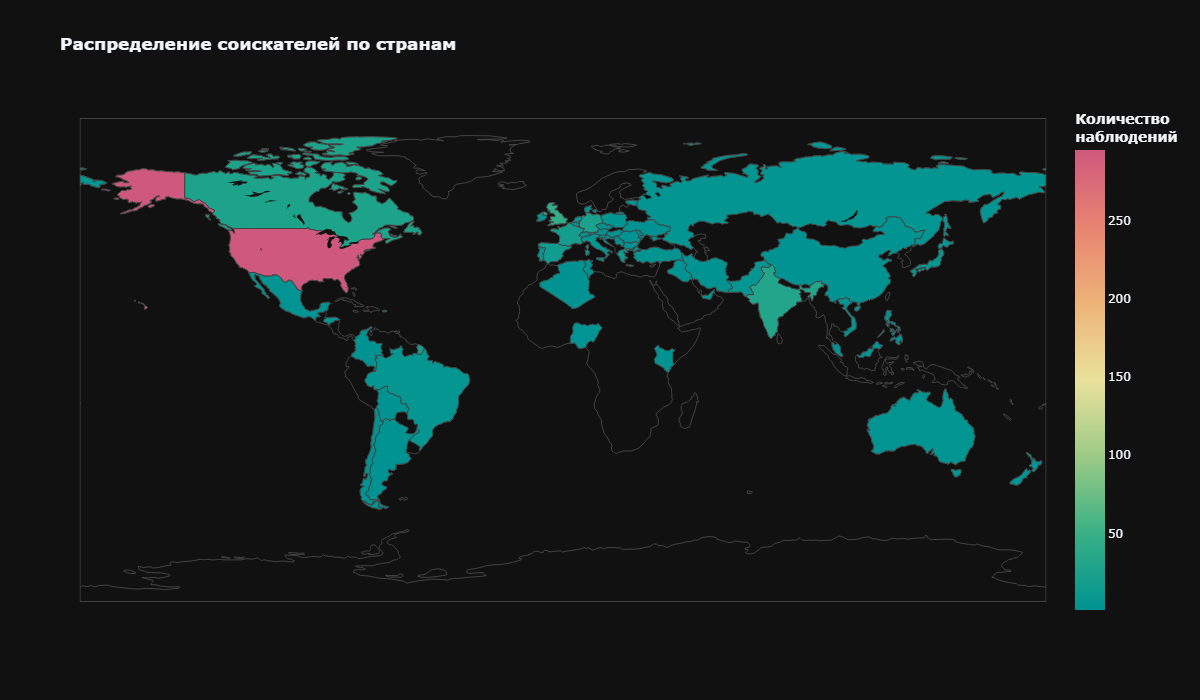

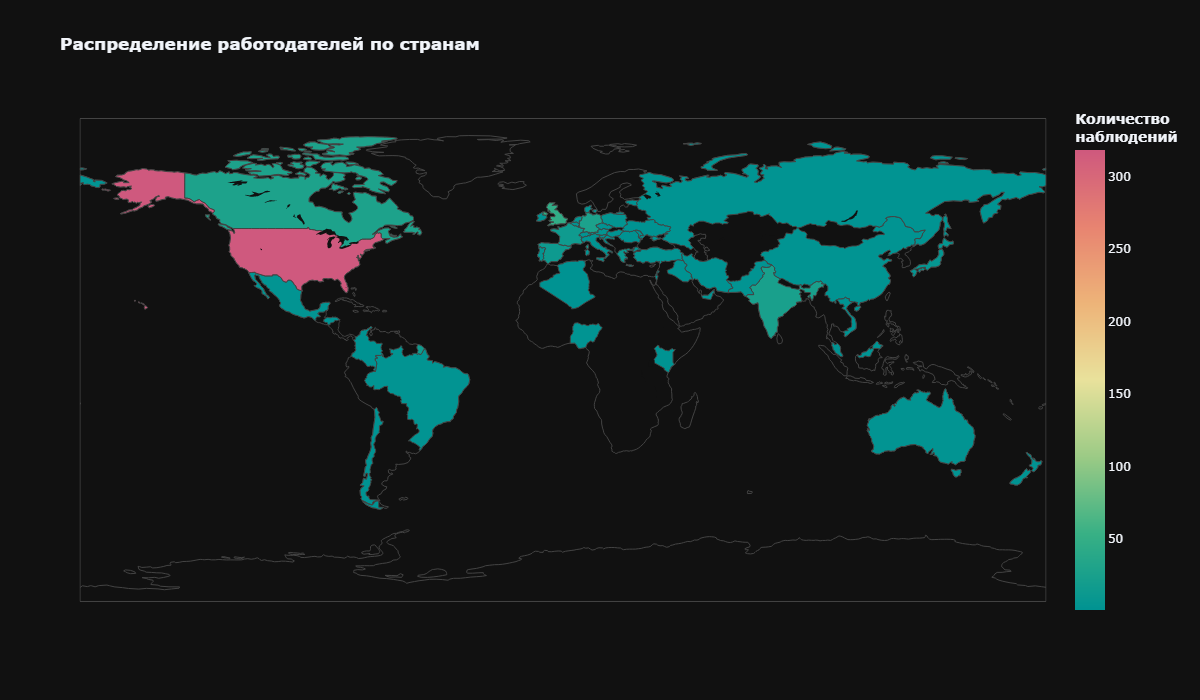

In [11]:
data['employee_residence'] = data['employee_residence'].apply(lambda x: country_alpha2_to_country_name(x))
data['company_location'] = data['company_location'].apply(lambda x: country_alpha2_to_country_name(x))

grouped_emp_res = data.groupby(
    by='employee_residence',
    as_index=False
)['company_location'].count().rename(columns={'company_location': 'count'})

grouped_comp_loc = data.groupby(
    by='company_location',
    as_index=False
)['employee_residence'].count().rename(columns={'employee_residence': 'count'})

px.choropleth(
    data_frame=grouped_emp_res,
    locationmode='country names',
    locations='employee_residence',
    color='count',
    color_continuous_scale=px.colors.diverging.Temps,
    width=1200,
    height=700,
    title='<b>Распределение соискателей по странам</b>'
).update_layout(coloraxis_colorbar_title='<b>Количество<br>наблюдений</b>').show()

px.choropleth(
    data_frame=grouped_comp_loc,
    locationmode='country names',
    locations='company_location',
    color='count',
    color_continuous_scale=px.colors.diverging.Temps,
    width=1200,
    height=700,
    title='<b>Распределение работодателей по странам</b>'
).update_layout(coloraxis_colorbar_title='<b>Количество<br>наблюдений</b>').show()

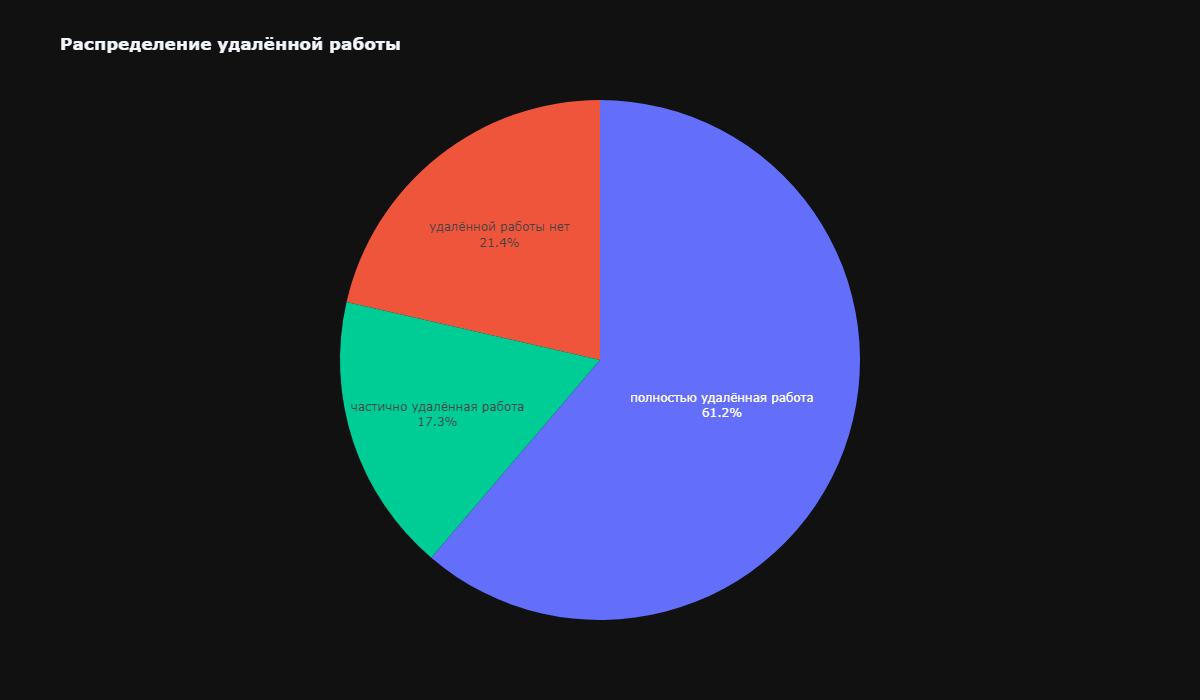

In [12]:
remote_dict = {
    0: 'удалённой работы нет',
    50: 'частично удалённая работа',
    100: 'полностью удалённая работа'
}
convert_remote = lambda x: remote_dict[x]
remote_ratio_df = pd.DataFrame(data['remote_ratio'].apply(convert_remote))

px.pie(
    data_frame=remote_ratio_df,
    names='remote_ratio',
    width=1200,
    height=700,
    title='<b>Распределение удалённой работы</b>'
).update_traces(
    textinfo='percent+label',
    textposition='inside'
).update_layout(
    showlegend=False
).show()

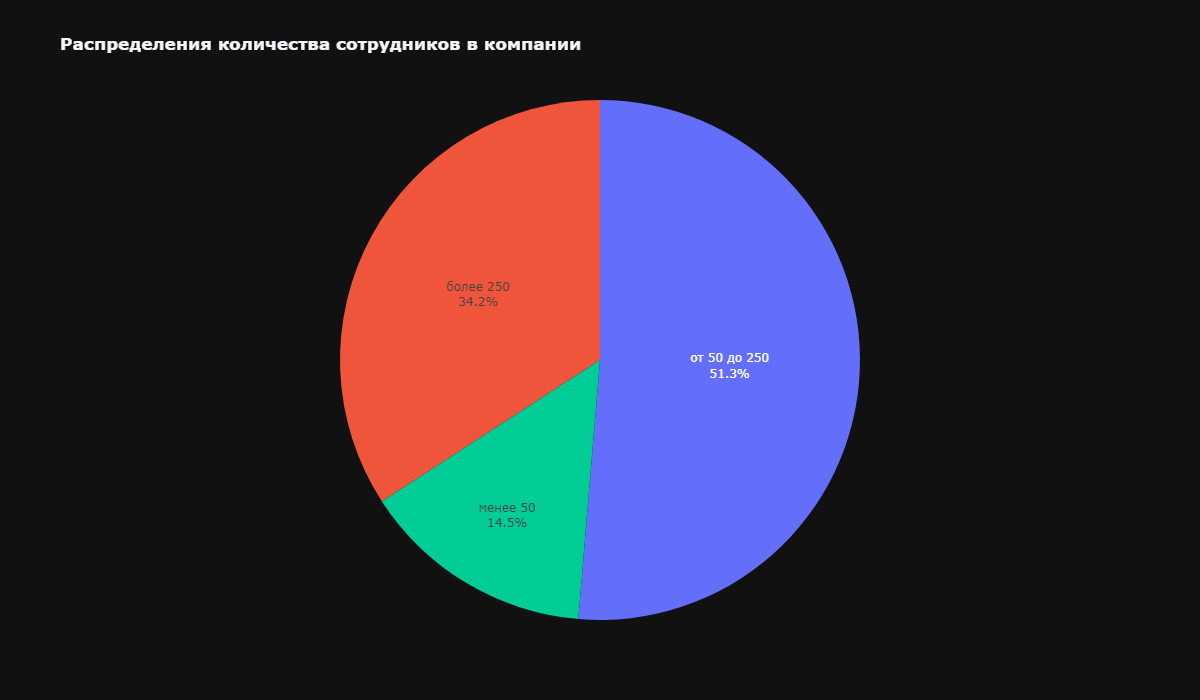

In [13]:
size_dict = {
    'S': 'менее 50',
    'M': 'от 50 до 250',
    'L': 'более 250'
}
convert_size = lambda x: size_dict[x]
comp_size_df = pd.DataFrame(data['company_size'].apply(convert_size))

px.pie(
    data_frame=comp_size_df,
    names='company_size',
    width=1200,
    height=700,
    title='<b>Распределения количества сотрудников в компании</b>'
).update_traces(
    textinfo='percent+label',
    textposition='inside'
).update_layout(
    showlegend=False
).show()

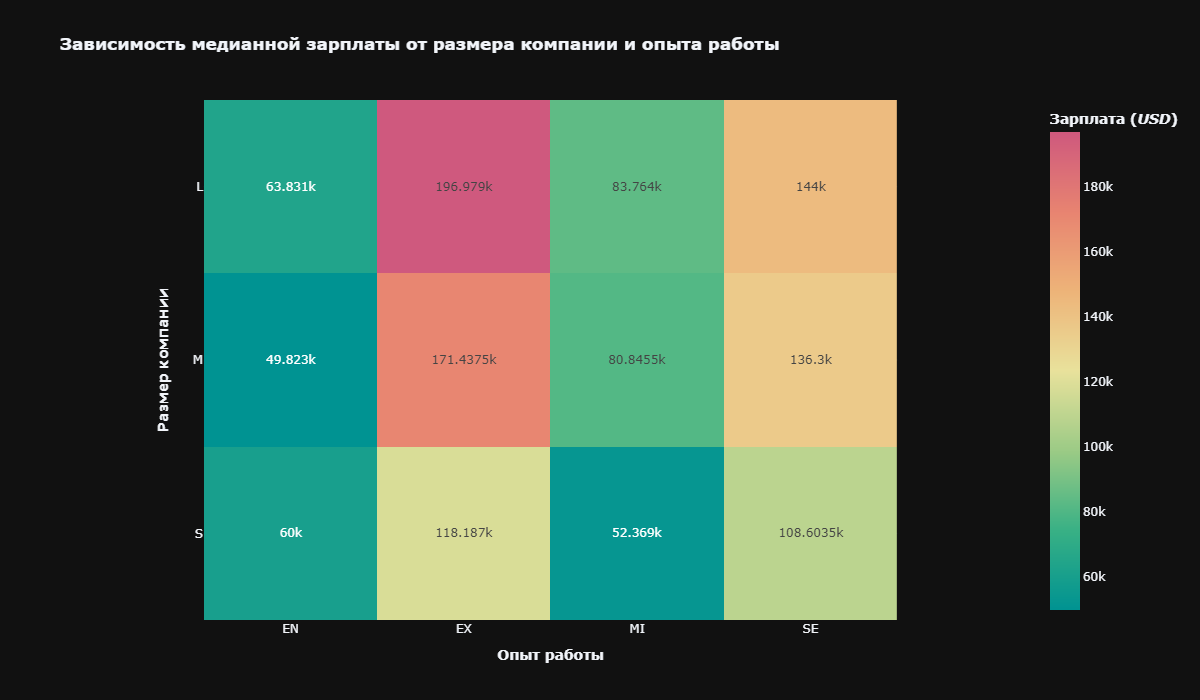

In [14]:
salary_pivot = data.pivot_table(
    values='salary_in_usd', 
    columns='experience_level',
    index='company_size',
    aggfunc='median'
)

px.imshow(
    salary_pivot,
    text_auto=True,
    width=1200,
    height=700,
    color_continuous_scale=px.colors.diverging.Temps,
    labels={
        'y': '<b>Размер компании</b>',
        'x': '<b>Опыт работы</b>',
        'color': '<b>Зарплата (<i>USD</i>)</b>'
    },
    title='<b>Зависимость медианной зарплаты от размера компании и опыта работы'
    
).update_layout(coloraxis_colorbar_title='<b>Зарплата (<i>USD</i>)</b>')

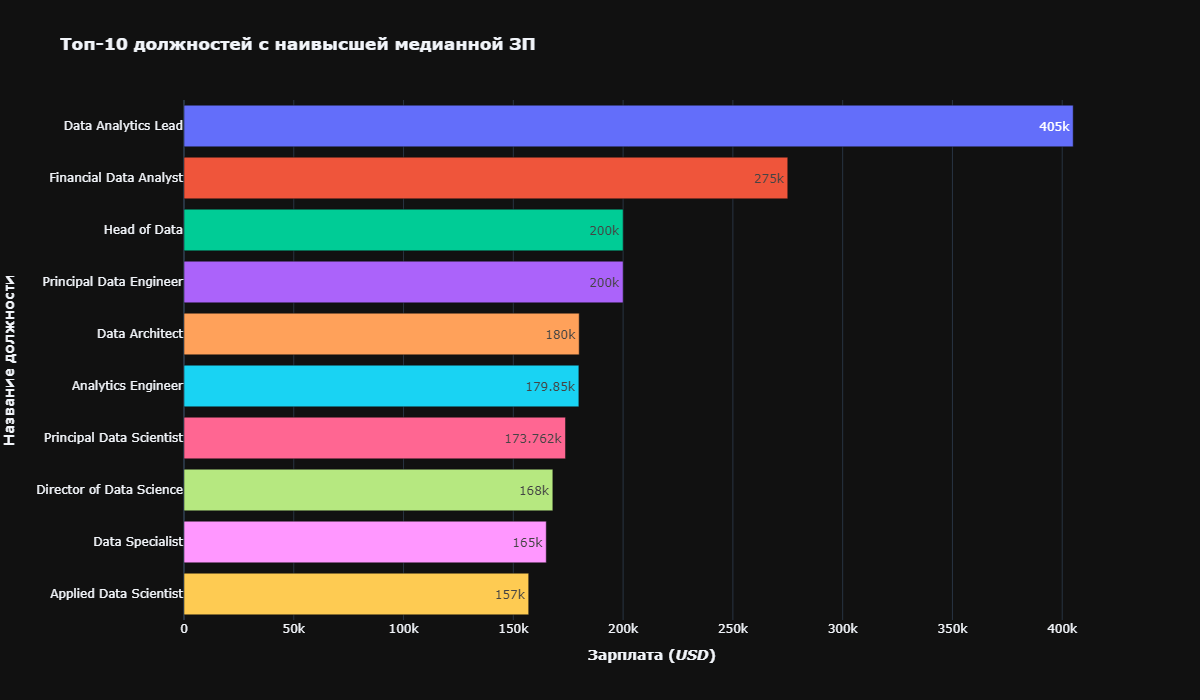

In [15]:
grouped_job_salary = data.groupby(
    by='job_title', 
    as_index=False
)['salary_in_usd'].median().sort_values(
    by='salary_in_usd',
    ascending=False
).head(10)

px.bar(
    grouped_job_salary,
    y='job_title',
    x='salary_in_usd',
    width=1200,
    height=700,
    title='<b>Топ-10 должностей с наивысшей медианной ЗП</b>',
    color='job_title',
    labels={
        'job_title': '<b>Название должности</b>',
        'salary_in_usd': '<b>Зарплата (<i>USD</i>)'
    },
    text_auto=True
).update_layout(showlegend=False)

Из графиков выше можно сделать первоначальные выводы:
* Признак зарплаты имеет логнормальное распределение
* В датасете преобладают данные о специалистах уровня *SE (Senior-level/Expert)* и *MI (Mid-level/Intermediate)*
* Почти во всех наблюдениях (96%) тип трудоустройства указан как *FT* (полный рабочий день)
* Топ-3 самых популярных профессии в датасете:
    1. *Data Scientist*
    2. *Data Engineer*
    3. *Data Analyst*
* Большая часть соискателей и работодателей находятся на территории США
* Самая высокая медианная зарплата (196k *USD*) у людей с опытом работы *EX (Executive-level/Director)* в крупных компаниях (более 250 чел.)
* Самая низкая медианная зарплата (49k *USD*) у людей с опытом работы *EN (Entry-level/Junior)* в средних компаниях (от 50 до 250 чел.)
* 60% вакансий - полностью удалённая работа
* Половина компаний из датасета имеет средний размер (от 50 до 250 чел.)
* Самая высокооплачиваемая должность - *Data Analytics Lead*
* На зарплату больше всего влияет в первую очередь опыт соискателя, во вторую - размер компании

### Ключевые вопросы HR-агенства

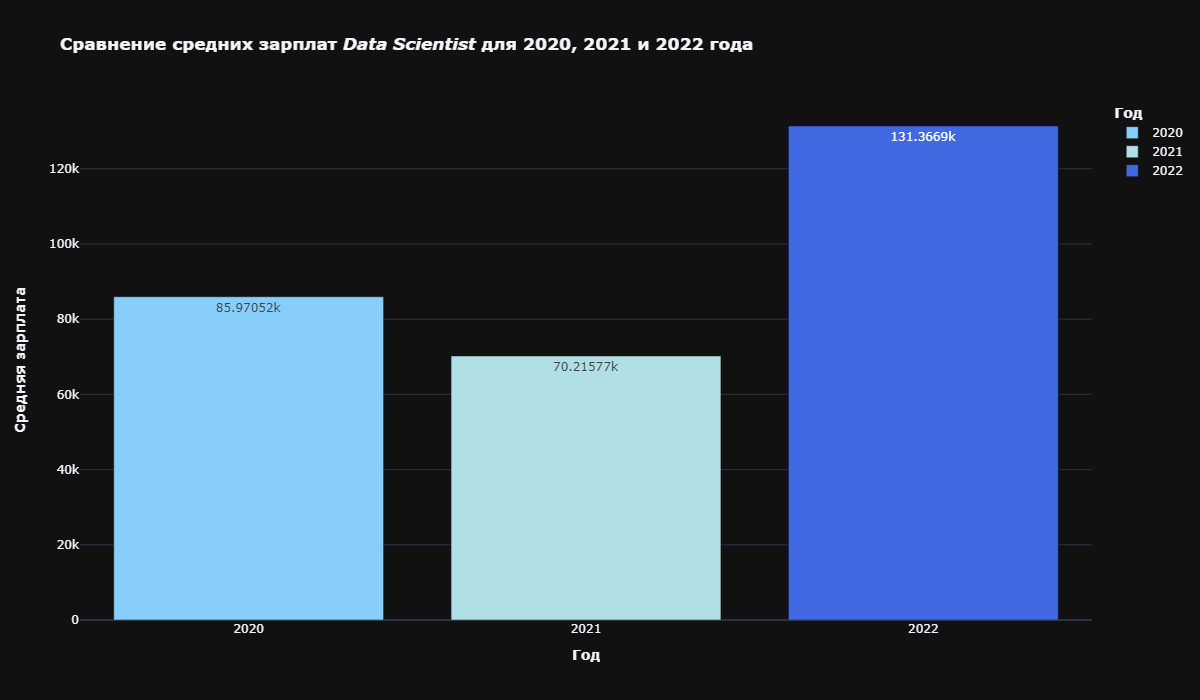

In [16]:
ds_jobs = data[data['job_title'] == 'Data Scientist']
grouped_ds_jobs = ds_jobs.groupby(by='work_year', as_index=False)['salary_in_usd'].mean()
grouped_ds_jobs['work_year'] = grouped_ds_jobs['work_year'].astype(object)

px.bar(
    grouped_ds_jobs,
    x='work_year',
    y='salary_in_usd',
    title='<b>Сравнение средних зарплат <i>Data Scientist</i> для 2020, 2021 и 2022 года</b>',
    width=1200,
    height=700,
    color='work_year',
    color_discrete_sequence=['#87CEFA', '#B0E0E6', '#4169E1'],
    text_auto=True,
    labels={'work_year': '<b>Год</b>', 'salary_in_usd': '<b>Средняя зарплата</b>'}
).update_xaxes(
    tickmode='linear',
    tick0=2020, 
    dtick=1
).show()

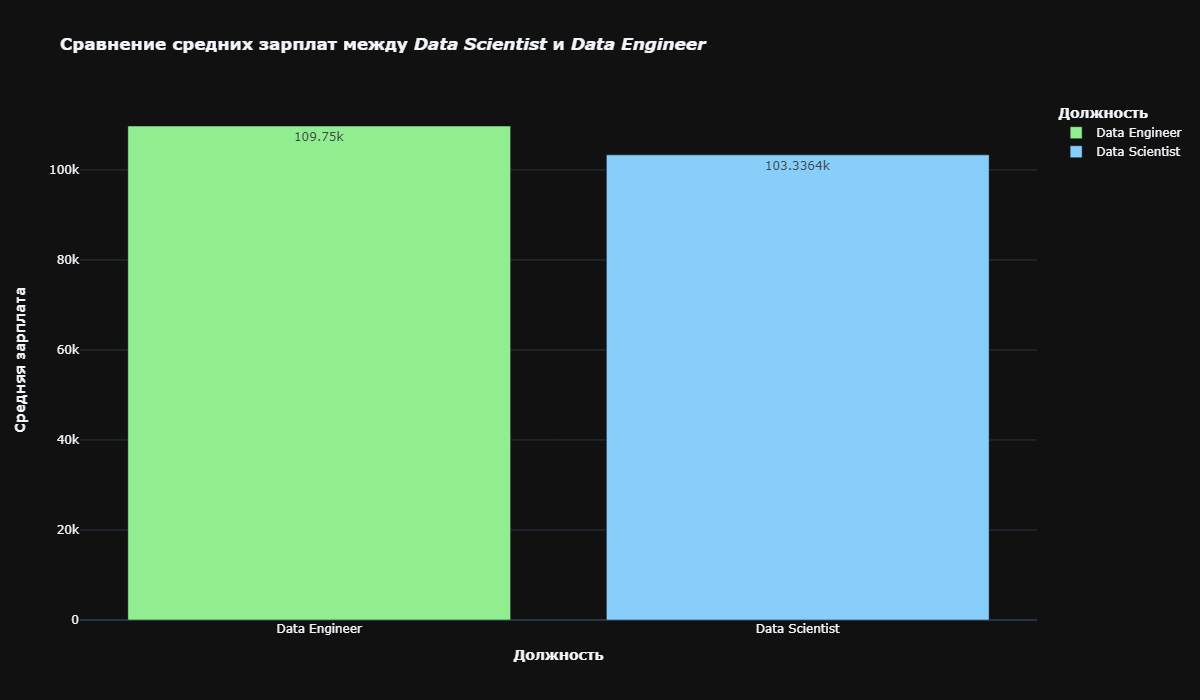

In [17]:
ds_de_jobs = data[data['job_title'].isin(['Data Scientist', 'Data Engineer'])]
grouped_ds_de_jobs = ds_de_jobs.groupby(by='job_title', as_index=False)['salary_in_usd'].mean()

px.bar(
    grouped_ds_de_jobs,
    y='salary_in_usd',
    x='job_title',
    color='job_title',
    width=1200,
    height=700,
    title='<b>Сравнение средних зарплат между <i>Data Scientist</i> и <i>Data Engineer</i></b>',
    text_auto=True,
    labels={'salary_in_usd': '<b>Средняя зарплата</b>', 'job_title': '<b>Должность</b>'},
    color_discrete_sequence=['#90EE90', '#87CEFA']
).show()

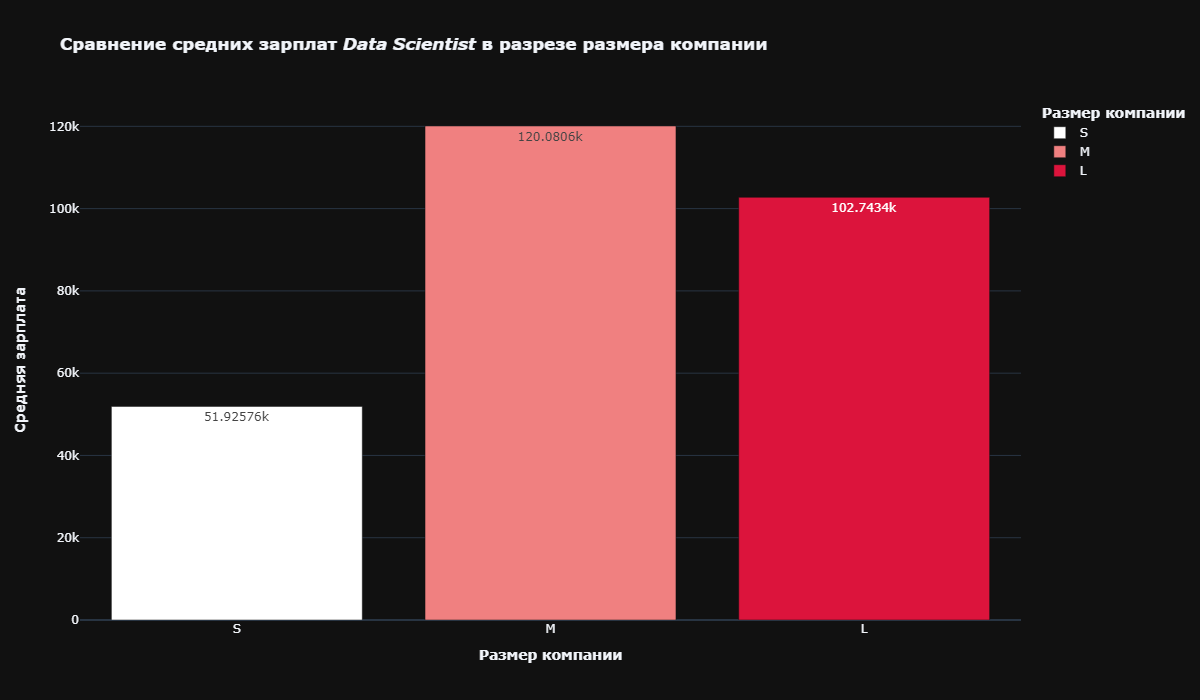

In [18]:
grouped_ds_size = ds_jobs.groupby(
    by='company_size', 
    as_index=False
)['salary_in_usd'].mean().sort_values(
    by='company_size', 
    ascending=False
)

px.bar(
    grouped_ds_size,
    x='company_size',
    y='salary_in_usd',
    color='company_size',
    width=1200,
    height=700,
    title='<b>Сравнение средних зарплат <i>Data Scientist</i> в разрезе размера компании</b>',
    text_auto=True,
    color_discrete_sequence=['#FFFFFF', '#F08080', '#DC143C'],
    labels={'company_size': '<b>Размер компании</b>', 'salary_in_usd': '<b>Средняя зарплата</b>'}
).update_xaxes(tickmode='array', tickvals=['S', 'M', 'L'])

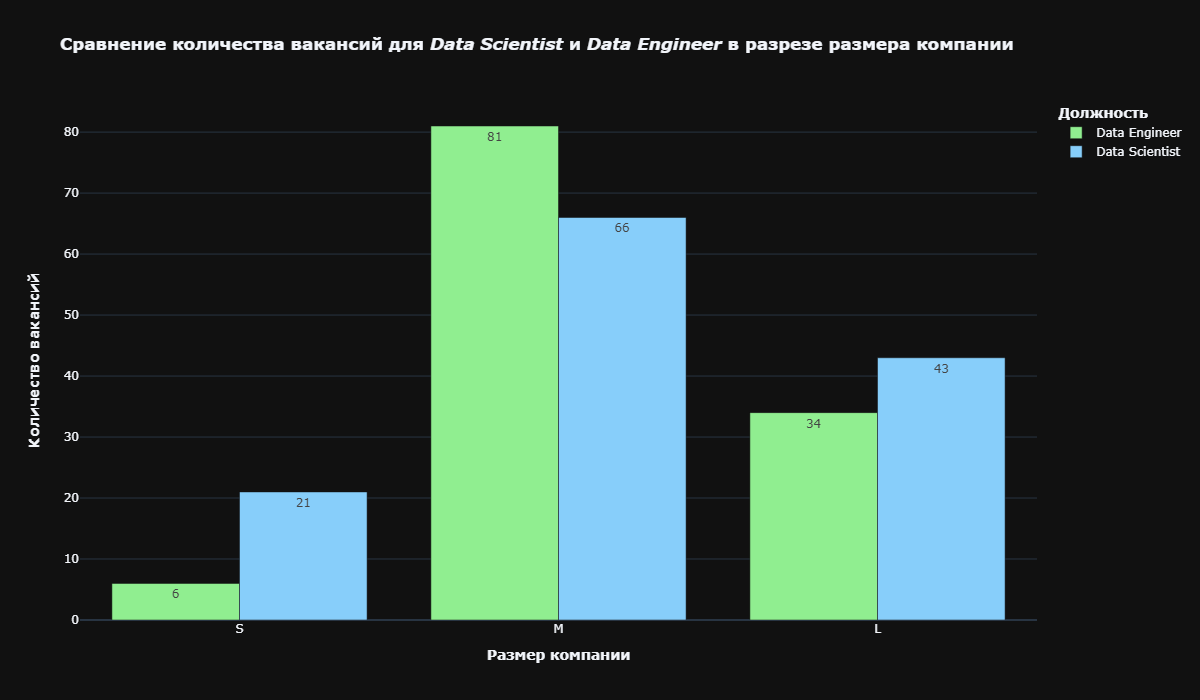

In [19]:
grouped_ds_de_size = ds_de_jobs.groupby(
    by=['company_size', 'job_title'],
    as_index=False
)['salary_in_usd'].count().rename(
    columns={'salary_in_usd': 'count'}
).sort_values(
    by='company_size',
    ascending=False
)

px.bar(
    grouped_ds_de_size,
    x='company_size',
    y='count',
    color='job_title',
    barmode='group',
    text_auto=True,
    title='<b>Сравнение количества вакансий для <i>Data Scientist</i> и <i>Data Engineer</i> в разрезе размера компании</b>',
    width=1200,
    height=700,
    labels={
        'count': '<b>Количество вакансий</b>',
        'job_title': '<b>Должность</b>',
        'company_size': '<b>Размер компании</b>'
    },
    color_discrete_sequence=['#90EE90', '#87CEFA']
).show()

Из графиков, относящихся к ключевым вопросам, можно отметить следующее:
* В 2022-ом году средняя зарплата *Data Scientist* стала намного выше, чем в 2020 и 2021 годах
* Особой разницы между зарплатами *Data Engineer* и *Data Scientist* не видно. Необходимо провести статистический тест, чтобы ответить на этот вопрос, т.к. по графику такая разница может быть просто погрешностью
* В компаниях малого размера (*S*) платят намного меньше, чем в компаниях среднего (*M*) и крупного (*L*) размера. Причем наибольшая средняя зарплата для *Data Scientist* приходится именно на компании размера *M*
* В компаниях малого размера очень мало вакансий для обеих должностей (*Data Engineer* и *Data Scientist*). Больше всего в таких сотрудниках нуждаются компании среднего размера. В крупных компаниях чаще нужен именно *Data Scientist*, а не *Data Engineer*

### Статистический анализ данных
#### Сравнение зарплат специалистов *Data Scientist* в зависимости от года
* **Нулевая гипотеза**: нет разницы между медианами ($\text{Me}$) зарплаты для *Data Scientist* в зависимости от года
    $$ H_0: \text{Me}_{2020} = \text{Me}_{2021} = \text{Me}_{2022} $$
* **Альтернативная гипотеза**: есть разница между медианами зарплаты для *Data Scientist* в зависимости от года
    $$ H_1: \text{Me}_{2020} \neq \text{Me}_{2021} \neq \text{Me}_{2022} $$


In [72]:
# Напишем функции для проверки гипотез, зададим начальный уровень alpha
alpha = 0.05

def test_normal(*samples):
    
    counter = 1
    for sample in samples:
        _, p_value = stats.shapiro(sample)
        print(f'Для выборки №{counter} {p_value=:.3f}')
        counter += 1
        if p_value <= alpha:
            print('Альтернативная гипотеза. Распределение отлично от нормального\n')
        else:
            print('Нулевая гипотеза. Распределение является нормальным\n')


def test_hypothesis(p_value):
    
    print(f'{p_value=:.3f}')
    if p_value <= alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Принимаем нулевую гипотезу')

In [73]:
# С помощью генератора получим 3 выборки для каждого года
ds_2020, ds_2021, ds_2022 = [
    data[
    (data['job_title'] == 'Data Scientist')
    & (data['work_year'] == year)
]['salary_in_usd'].values for year in data['work_year'].unique()
]

test_normal(ds_2020, ds_2021, ds_2022)

Для выборки №1 p_value=0.000
Альтернативная гипотеза. Распределение отлично от нормального

Для выборки №2 p_value=0.107
Нулевая гипотеза. Распределение является нормальным

Для выборки №3 p_value=0.676
Нулевая гипотеза. Распределение является нормальным



* Хотя бы одна из выборок не является нормально распределенной - **непараметрический тест**
* 3 независимые группы - **Критерий Краскела - Уоллиса**

In [74]:
_, p_value = stats.kruskal(ds_2020, ds_2021, ds_2022)
test_hypothesis(p_value)

p_value=0.000
Отвергаем нулевую гипотезу


>**Вывод:** существует разница в медианах зарплаты *Data Scientist* для каждого года. Если ссылаться на построенный график, то можно с уверенностью сказать, что в 2022 году зарплата стала больше, чем в предыдущих.
#### Сравнение средних зарплат *Data Engineer* и *Data Scientist*
* **Нулевая гипотеза**: средняя зарплата *Data Engineer* ($\mu_1$) меньше или равна, чем средняя зарплата *Data Scientist* ($\mu_2$).
    $$ H_0: \mu_1 \leq \mu_2 $$
* **Альтернативная гипотеза**: средняя зарплата *Data Engineer* больше, чем средняя зарплата *Data Scientist*
    $$ H_1: \mu_1 > \mu_2 $$

In [75]:
# Получим нужные выборки с помощью генератора и проверим их на нормальность
ds_salary, de_salary = [
    data[data['job_title'] == job]['salary_in_usd'].values
    for job in ['Data Scientist', 'Data Engineer']
]

test_normal(ds_salary, de_salary)

Для выборки №1 p_value=0.000
Альтернативная гипотеза. Распределение отлично от нормального

Для выборки №2 p_value=0.004
Альтернативная гипотеза. Распределение отлично от нормального



* Распределение отлично от нормального - **непараметрический тест**
* 2 независимые группы - **U-критерий Манна - Уитни**

In [76]:
_, p_value = stats.mannwhitneyu(de_salary, ds_salary, alternative='greater')
test_hypothesis(p_value)

p_value=0.164
Принимаем нулевую гипотезу


>**Вывод:** средняя зарплата *Data Engineer* меньше или равна, чем средняя зарплата *Data Scientist*. Та разница, что видна на графике, не является статистически значимой.
#### Сравнение зарплаты специалистов *Data Scientist* в зависимости от размера компании
* **Нулевая гипотеза**: нет разницы в медианной зарплате ($\text{Me}$) в компаниях разных размеров ($S, M, L$)
    $$ H_0: \text{Me}_S = \text{Me}_M = \text{Me}_L $$
* **Альтернативная гипотеза**: существует разница в медианной зарплате в компаниях разных размеров
    $$ H_1: \text{Me}_S \neq \text{Me}_M \neq \text{Me}_L $$

In [81]:
# Получим 3 выборки для каждого размера компании и проверим их на нормальность
ds_S, ds_M, ds_L = [
   ds_jobs[ds_jobs['company_size'] == job]['salary_in_usd'].values
   for job in ['S', 'M', 'L']
]

test_normal(ds_S, ds_M, ds_L)

Для выборки №1 p_value=0.189
Нулевая гипотеза. Распределение является нормальным

Для выборки №2 p_value=0.897
Нулевая гипотеза. Распределение является нормальным

Для выборки №3 p_value=0.000
Альтернативная гипотеза. Распределение отлично от нормального



* Хотя бы в одной группе распределение отлично от нормального - **непараметрический тест**
* 3 независимые группы - **Критерий Краскела - Уоллиса**

In [85]:
_, p_value = stats.kruskal(ds_S, ds_M, ds_L)
test_hypothesis(p_value)

p_value=0.000
Отвергаем нулевую гипотезу


>**Вывод:** зарплата *Data Scientist* зависит от размера компании.
#### Сравнение количества вакансий для *Data Scientist* и *Data Engineer* в разрезе размера компании
* **Нулевая гипотеза**: количество вакансий не зависит от размера компании и должности
* **Альтернативная гипотеза**: количество вакансий зависит от размера компании и должности

In [92]:
ds_de_crosstab = pd.crosstab(index=ds_de_jobs['company_size'], columns=ds_de_jobs['job_title'])
ds_de_crosstab

job_title,Data Engineer,Data Scientist
company_size,,
L,34,43
M,81,66
S,6,21


* Сравниваем связь между двумя категориальными признаками (`job_title` и `company_size`) - **критерий $\chi^2$**

In [93]:
_, p_value, _, _ = stats.chi2_contingency(ds_de_crosstab)
test_hypothesis(p_value)

p_value=0.005
Отвергаем нулевую гипотезу


>**Вывод:** количество вакансий *Data Scientist* и *Data Engineer* зависит от размера компании.